# Anomaly or Novelty?

**Anomalies are outliers that are known to be present in the training data and deviate from what is normal or expected.** In such cases, we should aim to fit a model on the observations that have the expected/normal behavior (also named inliers) and ignore the deviant observations. The observations that fall outside the expected/normal behavior are the outliers.

**Novelties are outliers that are not known to be present in the training data. The data does not contain observations that deviate from what is normal/expected.** Novelty detection can be more challenging as there is no reference of an outlier. Domain knowledge is more important in such cases to prevent model overfitting on the inliers.

# Outliers Can Fall into Three Categories.

- **Global outliers** (also named point outliers) are single, and independent observations that deviate from all other observations. When someone speaks about “outliers”, it is usually about the global outlier.

- **Contextual outliers** occur when a particular observation doesn’t fit in a specific context. A context can present itself in a bimodal or multimodal distribution, and an outlier deviates within the context. For instance, temperatures below 0 are normal in winter but are unusual in the summer and are then called outliers. Besides time series and seasonal data, other known applications are in sensor data and security operations.

- **Collective outliers** (or group outliers) are a group of similar/related instances with unusual behavior compared to the rest of the data set. The group of outliers can form a bimodal or multimodal distribution because they often indicate a different type of problem than individual outliers, such as a batch processing error or a systemic problem in the data generation process. Note that the Detection of collective outliers typically requires a different approach than detecting individual outliers.

# Outliers can be Modeled in a Univariate or Multivariate manner.

- **The univariate** approach is when the sample/observation is marked as an outlier using one variable at a time, i.e., a person’s age, weight, or a single variable in time series data. Analyzing the data distribution in such cases is well-suited for outlier detection.

- **The multivariate** approach is when the sample/observations contain multiple features that can be jointly analyzed, such as age, weight, and height together. It is well suited to detect outliers with features that have (non-)linear relationships or where the distribution of values in each variable is (highly) skewed. In these cases, the univariate approach may not be as effective, as it does not take into account the relationships between variables.

# Outlier Detection in Univariate Variables Using Distribution Fitting.

There are various (non-)parametric manners for the detection of outliers in univariate data sets, such as Z-scores, Tukey’s fences, and density-based approaches among others. The common theme across the methods is that the underlying distribution is modeled. The distfit library is therefore well suited for outlier detection as it can determine the Probability Density Function (PDF) for univariate random variables but can also model univariate data sets in a non-parametric manner using percentiles or quantiles. Moreover, it can be used to model anomalies or novelties in any of the three categories; global, contextual, or collective outliers.

The modeling approach can be summarized as follows:

1. Compute the fit for your random variable across various PDFs, then rank PDFs using the goodness of fit test, and evaluate with a bootstrap approach. *Note that non-parametric approaches with quantiles or percentiles can also be used.*

2. Visually inspect the histogram, PDFs, CDFs, and Quantile-Quantile (QQ) plot.
3. Choose the best model based on steps 1 and 2, but also make sure the properties of the (non-)parametric model (e.g., the PDF) match the use case. *Choosing the best model is not just a statistical question; it is also a modeling decision.*

4. Make predictions on new unseen samples using the (non-)parametric model such as the PDF.

# Novelty detection for continuous random variables.

Let’s start with a simple and intuitive example to demonstrate the working of novelty detection for univariate variables using distribution fitting and hypothesis testing. In this example, our aim is to pursue a novelty approach for the detection of global outliers, i.e., the data does not contain observations that deviate from what is normal/expected. This means that, at some point, we should carefully include domain knowledge to set the boundaries of what an outlier looks like.

Suppose we have measurements of 10.000 human heights. Let’s generate random normal data with mean=163 and std=10 that represents our human height measurements. We expect a bell-shaped curve that contains two tails; those with smaller and larger heights than average. *Note that due to the stochastic component, results can differ slightly when repeating the experiment.*

In [1]:
# Import library
import numpy as np

# Generate 10000 samples from a normal distribution
X = np.random.normal(163, 10, 10000)

### Step 1. Determine the PDFs that best fit Human Height.

Before we can detect any outliers, we need to fit a distribution (PDF) on what is normal/expected behavior for human height. The distfit library can fit up to 89 theoretical distributions. I will limit the search to only common/popular probability density functions as we readily expect a bell-shaped curve (see the following code section).

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm      ] [0.29 sec] [RSS: 7.02521e-05] [loc=163.048 scale=9.976]                                  
[distfit] >INFO> [expon     ] [0.27 sec] [RSS: 0.0176482] [loc=122.866 scale=40.181]                                   
[distfit] >INFO> [pareto    ] [23.9 sec] [RSS: 0.0195862] [loc=-0.312 scale=123.178]                                   
[distfit] >INFO> [dweibull  ] [10.7 sec] [RSS: 0.000341286] [loc=163.257 scale=8.493]                                  
[distfit] >INFO> [t         ] [17.9 sec] [RSS: 7.02465e-05] [loc=163.047 scale=9.976]                                  
[distfit] >INFO> [genextreme] [59.2 sec] [RSS: 0.0374082] [loc=203.887 scale=2.967]                                    
[distfit] >INFO> [gamma     ] [12.9 sec] [RSS: 7.27533e-05] [loc=-1419.846 scale=0.063]                                
[distfit] >INFO> [lognorm   ] [36.0 sec] [RSS: 7.73857e-05] [loc=-651.053 scale=814.063]                        

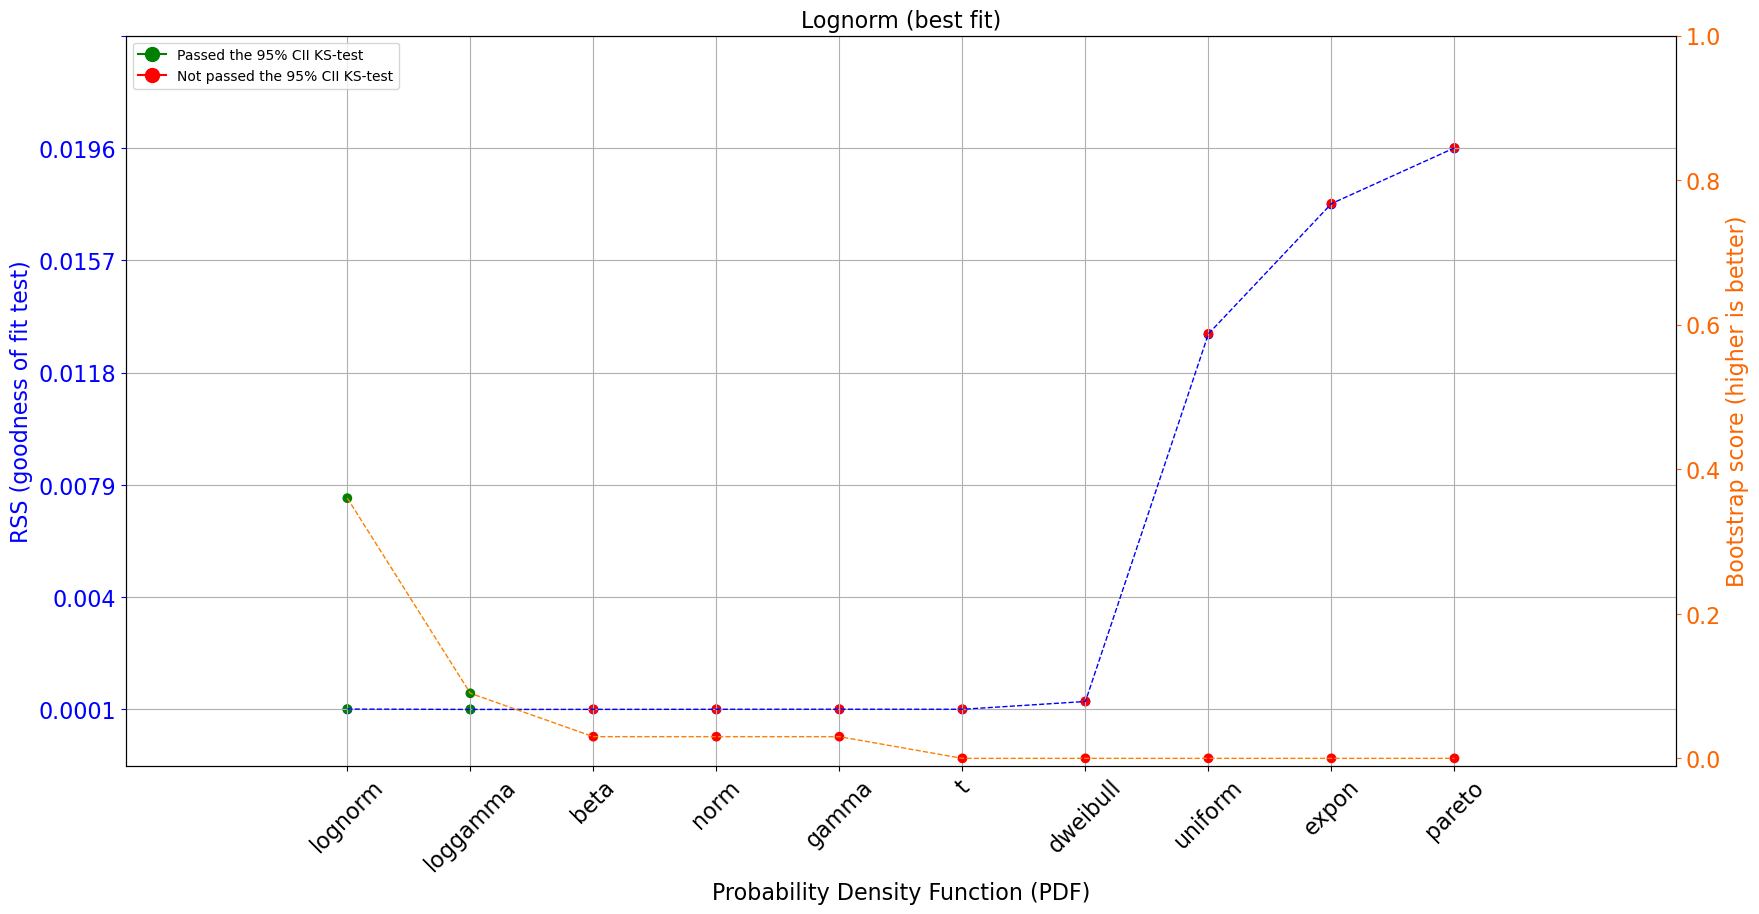

In [2]:
# Import library
from distfit import distfit
import matplotlib.pyplot as plt

# Initialize for common/popular distributions with bootstrapping.
dfit = distfit(distr='popular', n_boots=100)

# Estimate the best fit
results = dfit.fit_transform(X)

# Plot the RSS and bootstrap results for the top scoring PDFs
dfit.plot_summary(n_top=10)

# Show the plot
plt.show()

The **loggamma** PDF is detected as the best fit for human height according to the goodness of fit test statistic (RSS) and the bootstrapping approach. Note that the bootstrap approach evaluates whether there was overfitting for the PDFs. The bootstrap score ranges between, and depicts the fit-success ratio across the number of bootstraps (n_bootst=100) for the PDF. It can also be seen from Figure 3 that, besides the loggamma PDF, multiple other PDFs are detected too with a low Residual Sum of Squares, i.e., Beta, Gamma, Normal, T-distribution, Loggamma, generalized extreme value, and the Weibull distribution (Figure 3). However, only five PDFs did pass the bootstrap approach.

### Step 2: Visual inspection of the best-fitting PDFs.

A best practice is to visually inspect the distribution fit. The distfit library contains built-in functionalities for plotting, such as the histogram combined with the PDF/CDF but also QQ-plots. The plot can be created as follows:

[distfit] >INFO> Create PDF plot for the parametric method.
[distfit] >INFO> Estimated distribution: Lognorm(loc:-651.052774, scale:814.062520)
[distfit] >INFO> Create CDF plot for the parametric method.
[distfit] >INFO> Ploting CDF


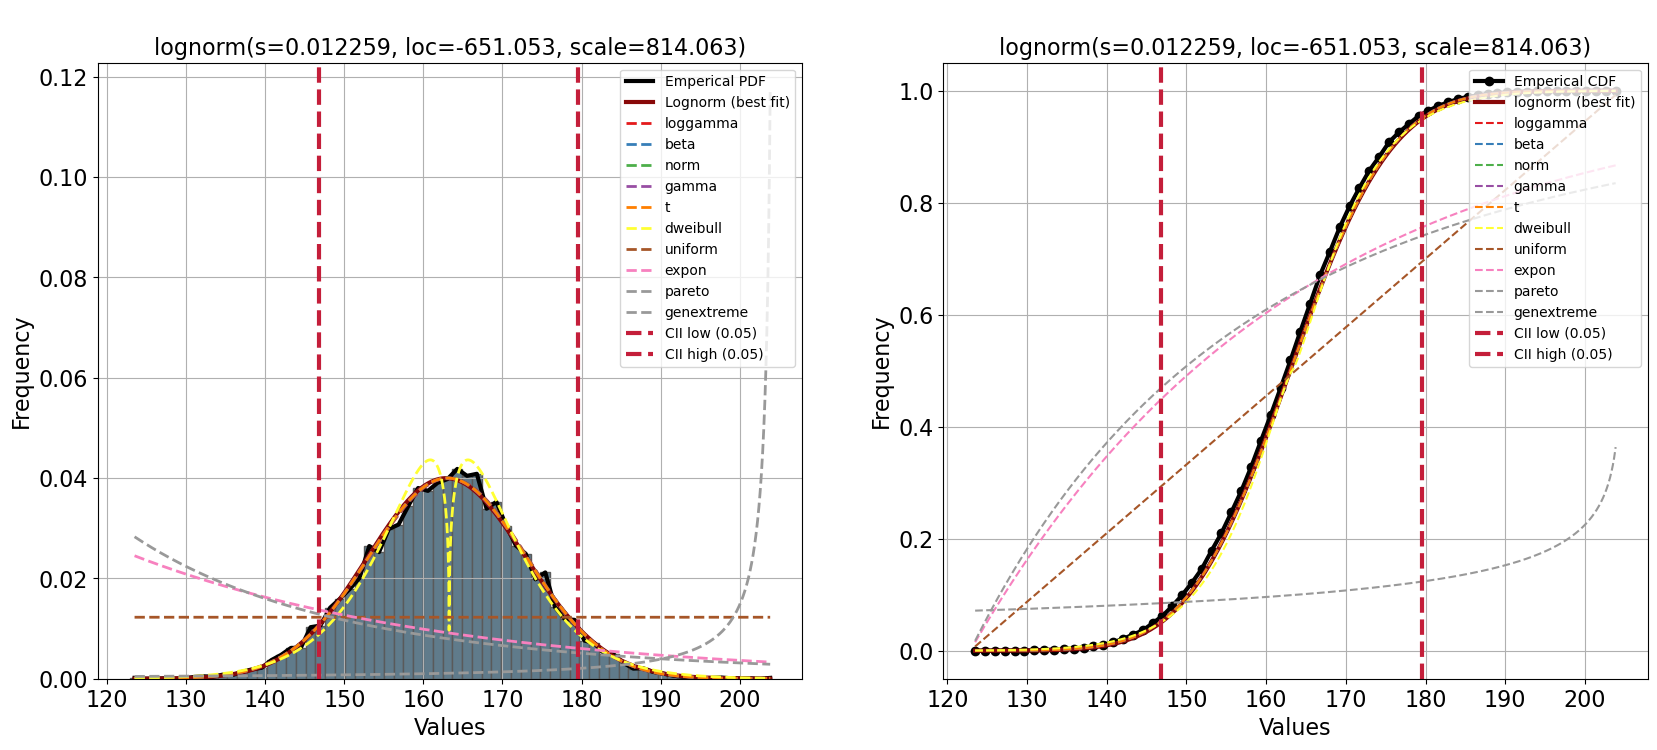

In [3]:
# Make figure
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

# PDF for only the best fit
dfit.plot(chart='PDF', n_top=10, ax=ax[0]);

# CDF for the top 10 fits
dfit.plot(chart='CDF', n_top=10, ax=ax[1])

# Show the plot
plt.show()

A visual inspection confirms the goodness of fit scores for the top-ranked PDFs. However, there is one exception, the Weibull distribution (yellow line in Figure 4) appears to have two peaks. In other words, although the RSS is low, a visual inspection does not show a good fit for our random variable. *Note that the bootstrap approach readily excluded the Weibull distribution and now we know why.*

### Step 3: Decide by also using the PDF properties.

The last step may be the most challenging step because there are still five candidate distributions that scored very well in the goodness of fit test, the bootstrap approach, and the visual inspection. We should now decide which PDF matches best on its fundamental properties to model human height. I will stepwise elaborate on the properties of the top candidate distributions with respect to our use case of modeling human height.

**The Normal distribution** is a typical choice but it is important to note that the assumption of normality for human height may not hold in all populations. It has no heavy tails and therefore it may not capture outliers very well.

**The Students T-distribution** is often used as an alternative to the normal distribution when the sample size is small or the population variance is unknown. It has heavier tails than the normal distribution, which can better capture the presence of outliers or skewness in the data. In case of low sample sizes, this distribution could have been an option but as the sample size increases, the t-distribution approaches the normal distribution.

**The Gamma distribution** is a continuous distribution that is often used to model data that are positively skewed, meaning that there is a long tail of high values. Human height may be positively skewed due to the presence of outliers, such as very tall individuals. However, the bootstrap appraoch showed a poor fit.

**The Log-gamma distribution** has a skewed shape, similar to the gamma distribution, but with heavier tails. It models the log of the values which makes it more appropriate to use when the data has large number of high values.

**The Beta distribution** is typically used to model proportions or rates [9], rather than continuous variables such as in our use-case for height. It would have been an appropriate choice if height was divided by a reference value, such as the median height. So despite it scores best on the goodness of fit test, and we confirm a good fit using a visual inspection, it would not be my first choice.

**The Generalized Extreme Value (GEV) distribution** can be used to model the distribution of extreme values in a population, such as the maximum or minimum values. It also allows heavy tails which can capture the presence of outliers or skewness in the data. However, it is typically used to model the distribution of extreme values [10], rather than the overall distribution of a continuous variable such as human height.

**The Dweibull distribution** may not be the best match for this research question as it is typically used to model data that has a monotonic increasing or decreasing trend, such as time-to-failure or time-to-event data [11]. Human height data may not have a clear monotonic trend. The visual inspection of the PDF/CDF/QQ-plot also showed no good match.

To summarize, the **loggamma** distribution may be the best choice in this particular use case after considering the goodness of fit test, the bootstrap approach, the visual inspection, and now also based on the PDF properties related to the research question. Note that we can easily specify the loggamma distribution and re-fit on the input data (see code section) if required (see code section).

In [4]:
# Initialize for common or popular distributions.
dfit = distfit(distr='loggamma', alpha=0.01, bound='both')

# Estimate the best fit
results = dfit.fit_transform(X)

# Print model parameters
print(dfit.model)

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [loggamma] [0.15 sec] [RSS: 6.54716e-05] [loc=-1537.880 scale=260.688]
[distfit] >INFO> Compute confidence intervals [parametric]


{'name': 'loggamma', 'score': 6.547159329066582e-05, 'loc': -1537.880493890084, 'scale': 260.68765273036524, 'arg': (682.308207564075,), 'params': (682.308207564075, -1537.880493890084, 260.68765273036524), 'model': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000020DCF994908>, 'bootstrap_score': 0, 'bootstrap_pass': None, 'color': '#e41a1c', 'CII_min_alpha': 139.53301373624822, 'CII_max_alpha': 185.98656493713497}


In [5]:
# # Save model
# dfit.save('./human_height_model.pkl')

### Step 4. Predictions for new unseen samples.

With the fitted model we can assess the significance of new (unseen) samples and detect whether they deviate from what is normal/expected (the inliers). Predictions are made on the theoretical probability density function, making it lightweight, fast, and explainable. The confidence intervals for the PDF are set using the `alpha` parameter. **This is the part where domain knowledge is required because there are no known outliers in our data set present.** In this case, I set the confidence interval (CII) `alpha=0.01` which results in a minimum boundary of 139.8cm and a maximum boundary of 185.8cm. The default is that both tails are analyzed but this can be changed using the `bound` parameter *(see code section above)*.

We can use the `predict` function to make new predictions on new unseen samples, and create the plot with the prediction results (Figure 5). Be aware that significance is corrected for multiple testing: `multtest='fdr_bh'`. *Outliers can thus be located outside the confidence interval but not marked as significant.*

In [6]:
# New human heights
y = [130, 160, 200]

# Make predictions
results = dfit.predict(y, alpha=0.01, multtest='fdr_bh', todf=True)

# The prediction results
results['df']

[distfit] >INFO> Alpha is set to [0.01]
[distfit] >INFO> Compute confidence intervals [parametric]
[distfit] >INFO> Compute significance for 3 samples.
[distfit] >INFO> Multiple test correction method applied: [fdr_bh].


,y,y_proba,y_pred,P
0,130.0,0.000873,down,0.000582
1,160.0,0.378128,none,0.378128
2,200.0,0.000230,up,0.000077


[distfit] >INFO> Create PDF plot for the parametric method.
[distfit] >INFO> Mark 2 significant regions
[distfit] >INFO> Estimated distribution: Loggamma(loc:-1537.880494, scale:260.687653)
[distfit] >INFO> Create CDF plot for the parametric method.
[distfit] >INFO> Ploting CDF
[distfit] >INFO> Mark 2 significant regions


<Figure size 640x480 with 0 Axes>

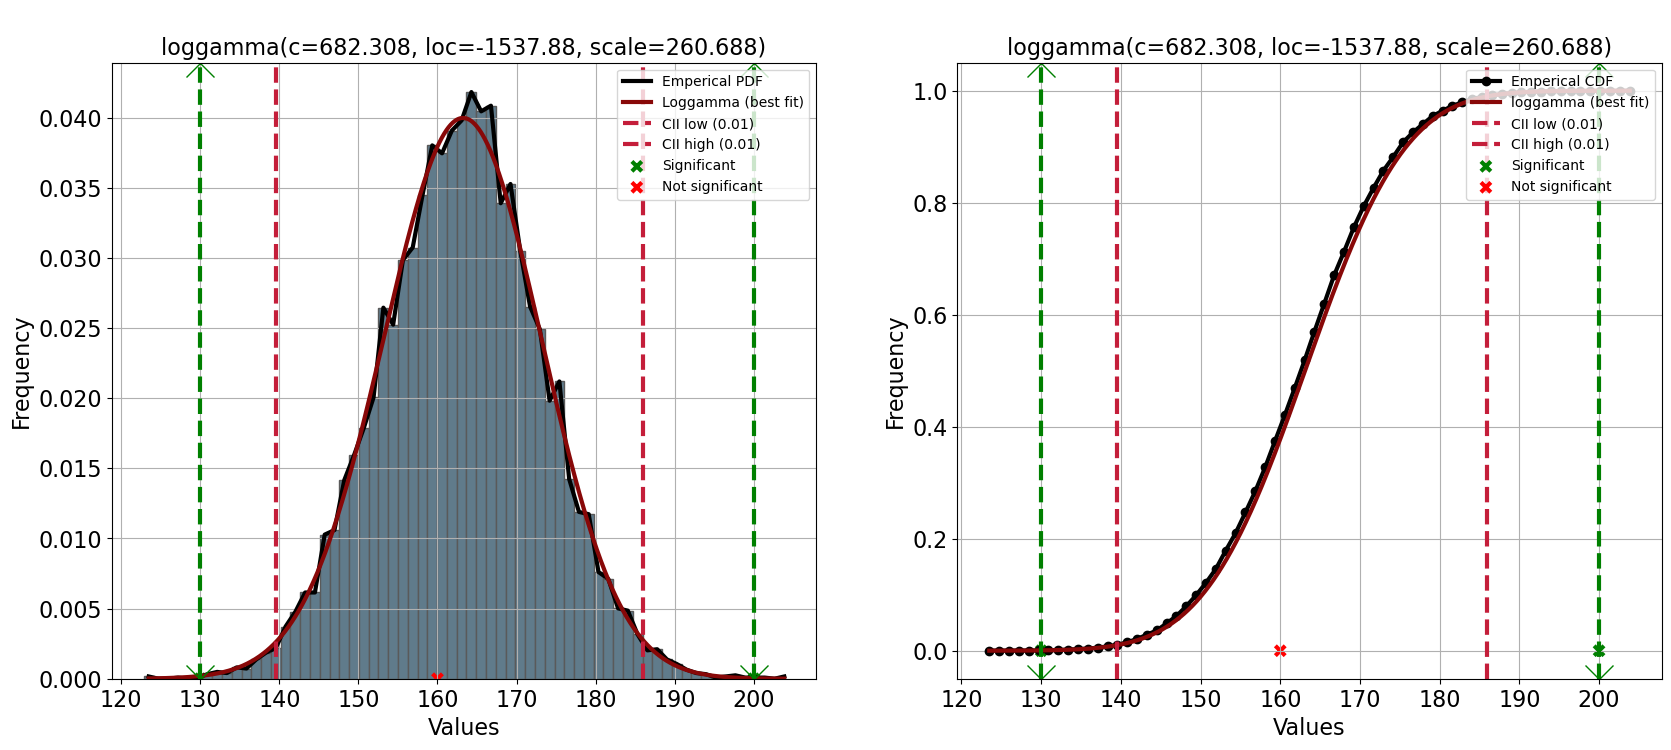

In [7]:
plt.figure();
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
# PDF for only the best fit
dfit.plot(chart='PDF', ax=ax[0]);
# CDF for the top 10 fits
dfit.plot(chart='CDF', ax=ax[1])
# Show plot
plt.show()

The results of the predictions are stored in `results` and contains multiple columns: `y`, `y_proba`, `y_pred`, and `P` . The `P` stands for the raw p-values and `y_proba` are the probabilities after multiple test corrections (default: `fdr_bh`). Note that a data frame is returned when using the `todf=True` parameter. Two observations have a probability `alpha<0.01` and are marked as significant `up` or `down`.

# Anomaly Detection in Real World data.

So far we have seen how to fit a model and detect global outliers for novelty detection. **Here we will use real-world data for the detection of anomalies.** The use of real-world data is usually much more challenging to work with. To demonstrate this, I will download the data set of natural gas spot price from Thomson Reuters which is an open-source and freely available dataset. After downloading, importing, and removing nan values, there are 6555 data points across 27 years.

In [8]:
# Initialize distfit
dfit = distfit()

# Import dataset
df = dfit.import_example(data='gas_spot_price')

print(df)

[distfit] >INFO> Downloading and processing [gas_spot_price] from github source.


            price
date             
2023-02-07   2.35
2023-02-06   2.17
2023-02-03   2.40
2023-02-02   2.67
2023-02-01   2.65
...           ...
1997-01-13   4.00
1997-01-10   3.92
1997-01-09   3.61
1997-01-08   3.80
1997-01-07   3.82

[6555 rows x 1 columns]


# Visually inspection of the data set.

To visually inspect the data, we can create a line plot of the natural gas spot price to see whether there are any obvious trends or other relevant matters (Figure 6). It can be seen that 2003 and 2021 contain two major peaks (which hint toward global outliers). Furthermore, the price actions seem to have a natural movement with local highs and lows. Based on this line plot, we can build an intuition of the expected distribution. The price moves mainly in the range (2, 5) but with some exceptional years from 2003 to 2009, where the range was more between (6, 9).

[distfit] >INFO> Dataframe detected. Labels are derived from the index and the data is flattened.
[distfit] >WARNING> No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


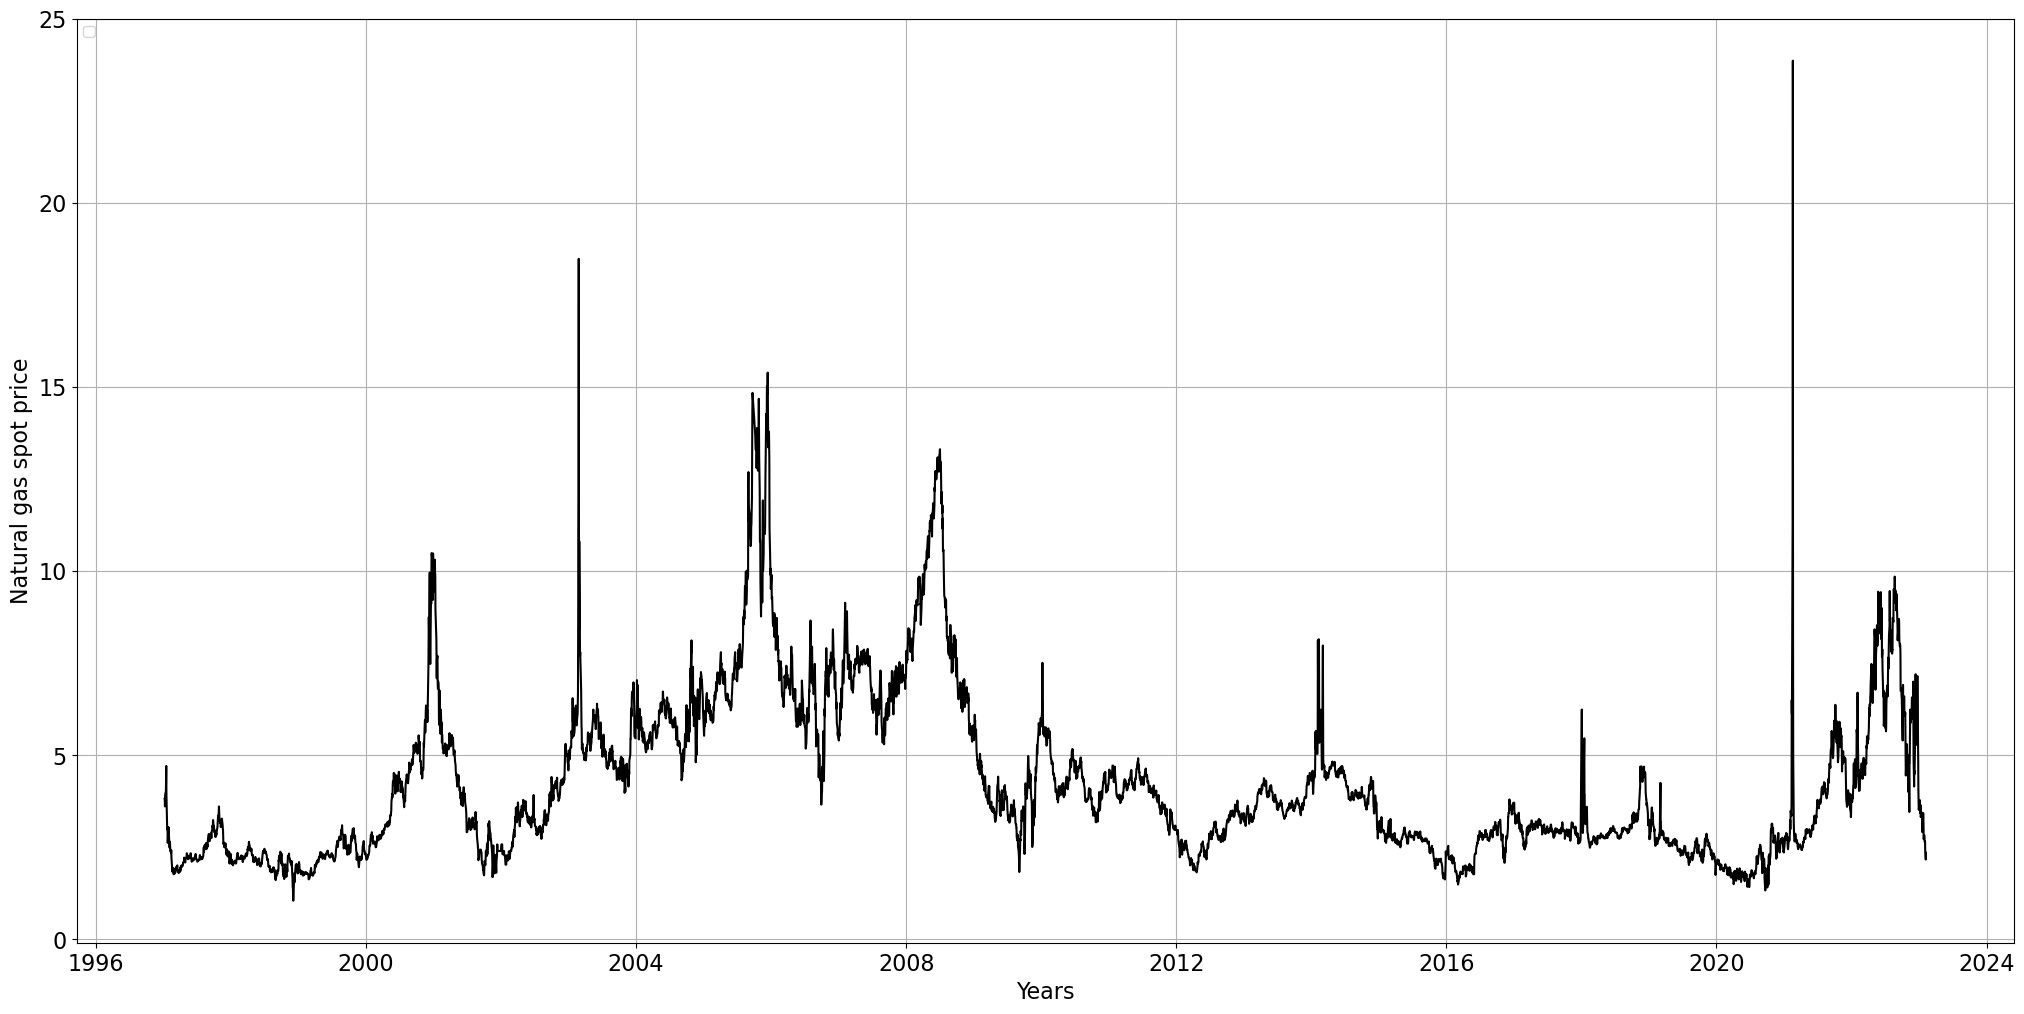

In [9]:
# Get unique years
dfit.lineplot(df, xlabel='Years', ylabel='Natural gas spot price', grid=True)

# Show the plot
plt.show()

Let’s use distfit to deeper investigate the data distribution, and determine the accompanying PDF. The search space is set to all available PDFs and the bootstrap approach is set to 100 to evaluate the PDFs for overfitting.

In [ ]:
# Fit distribution
dfit = distfit(distr='full', n_boots=100)

# Search for best theoretical fit.
results = dfit.fit_transform(df['price'].values)

# Plot PDF/CDF
fig, ax = plt.subplots(1,2, figsize=(25, 10))
dfit.plot(chart='PDF', n_top=10, ax=ax[0])
dfit.plot(chart='CDF', n_top=10, ax=ax[1])

# Show plot
plt.show()

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [alpha          ] [9.31 sec] [RSS: 0.0411] [loc=-1.372 scale=15.787]                                  
[distfit] >INFO> [anglit         ] [2.27 sec] [RSS: 0.374485] [loc=6.364 scale=11.494]                                 
[distfit] >INFO> [arcsine        ] [7.67 sec] [RSS: 0.548992] [loc=1.050 scale=22.810]                                 
[distfit] >INFO> [beta           ] [22.2 sec] [RSS: 0.0545361] [loc=1.047 scale=25085.315]                             
[distfit] >INFO> [betaprime      ] [25.7 sec] [RSS: 0.0322894] [loc=0.679 scale=0.496]                                 
[distfit] >INFO> [bradford       ] [10.8 sec] [RSS: 0.357667] [loc=1.050 scale=22.810]                                 
[distfit] >INFO> [burr           ] [66.9 sec] [RSS: 0.0340018] [loc=-0.829 scale=1.382]                                
[distfit] >INFO> [cauchy         ] [1.14 sec] [RSS: 0.115343] [loc=3.342 scale=1.023]                           

The best-fitting PDF is Johnsonsb (Figure 7) but when we plot the empirical data distributions, the PDF (red line) does not precisely follow the empirical data. In general, we can confirm that the majority of data points are located in the range (2, 5) (this is where the peak of the distribution is) and that there is a second smaller peak in the distribution with price actions around value 6. This is also the point where the PDF does not smoothly fit the empirical data and causes some undershoots and overshoots. With the summary plot and QQ plot, we can investigate the fit even better. Let’s create these two plots with the following lines of code:

In [ ]:
# Plot Summary and QQ-plot
fig, ax = plt.subplots(1,2, figsize=(25, 10))

# Summary plot
dfit.plot_summary(ax=ax[0])

# QQplot
dfit.qqplot(df['price'].values, n_top=10, ax=ax[1])

# Show the plot
plt.show()

It is interesting to see in the summary plot that the goodness of fit test showed good results (low score) among all the top distributions. However, when we look at the results of the bootstrap approach, it shows that all, except one distribution, are overfitted (Figure 8A, orange line). This is not entirely unexpected because we already noticed overshooting and undershooting. The QQ plot confirms that the fitted distributions deviate strongly from the empirical data (Figure 8B). Only the Johnsonsb distribution showed a (borderline) good fit.

# Detection of Global and Contextual Outliers.

We will continue using the Johnsonsb distribution and the `predict` functionality for the detection of outliers. We already know that our data set contains outliers as we followed the anomaly approach, i.e., *the distribution is fitted on the inliers, and observations that now fall outside the confidence intervals can be marked as potential outliers.* With the `predict` function and the `lineplot` we can detect and plot the outliers. It can be seen from Figure 9 that the global outliers are detected but also some contextual outliers, despite we did not model for it explicitly. **Red bars** are the underrepresented outliers and **green bars** are the overrepresented outliers. The `alpha` parameter can be set to tune the confidence intervals.

In [ ]:
# Make prediction
dfit.predict(df['price'].values, alpha=0.05, multtest=None)

# Line plot with data points outside the confidence interval.
dfit.lineplot(df['price'], labels=df.index)